# 1. Environment Setup

In [88]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

import statistics as st

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [89]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arnold\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# 2. Getting the data

In [90]:
query = "(insurance OR insured OR insurer OR underwriter OR insure) -is:retweet near:Nairobi within:200km lang:en since:2020-01-01 until:2022-12-31"
tweets_list = []

In [91]:
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
   tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

In [92]:
insurance_list = pd.DataFrame(tweets_list,columns =["Date","Id","Content","Username"])
insurance_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Date      2737 non-null   datetime64[ns, UTC]
 1   Id        2737 non-null   int64              
 2   Content   2737 non-null   object             
 3   Username  2737 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 85.7+ KB


In [93]:
insurance_list["Date"] = pd.to_datetime(insurance_list["Date"]).dt.date
insurance_list.sort_values(by="Date",ascending=True,inplace=True)
insurance_list["Id"] = insurance_list["Id"].astype(str)
insurance_list.head()

,Date,Id,Content,Username
2736,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma
2735,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu
2734,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira
2733,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola
2731,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya


# 3. Data Cleaning

In [94]:
#Util function for cleaning text
def cleaning_text(tweet_text):
    #making text lower text
    cleaned_content = tweet_text.lower()
    #removing URLs
    cleaned_content = re.sub(r"https\S+|www\S+https\S+","",cleaned_content,flags = re.MULTILINE)
    #removing whitespaces
    cleaned_content = re.sub(r"\n\s+","",cleaned_content)
    #removing punctuation
    cleaned_content = re.sub(r'[^\w\s]','',cleaned_content)
    return cleaned_content


# 4. Feature Engineering

In [95]:
#Extracting hashtags from the tweets
insurance_list["Hashtags"] = insurance_list["Content"].apply(lambda x: re.findall(r"#(\w+)",x)).apply(tuple).astype(str)

insurance_list["Cleaned Content"] = insurance_list["Content"].apply(cleaning_text)

#Extracting count per tweet
word_count = insurance_list["Content"].apply(lambda words: len(re.findall(r"\w+",words)))
insurance_list['Word Count'] = word_count
insurance_list.head()

,Date,Id,Content,Username,Hashtags,Cleaned Content,Word Count
2736,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma,(),marvingakunyi it has alot of humility in it ho...,33
2735,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu,"('UHC',)",healthcare financing nhifkenya enhanced nhif u...,44
2734,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira,(),this cancer insurance cover by icealion is wha...,17
2733,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola,"('SocialGood', 'DigitalHumanitarian', 'ItCould...",autoxpresskenya to the rescue after tyre bur...,41
2731,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya,(),johnkieti ma3route policeke no its actually co...,50


# 5. Data Overview

In [96]:
insurance_list.isna().sum()

Date               0
Id                 0
Content            0
Username           0
Hashtags           0
Cleaned Content    0
Word Count         0
dtype: int64

In [97]:
insurance_list.Id.describe()

count                    2737
unique                   2737
top       1212788197161406469
freq                        1
Name: Id, dtype: object

In [98]:
insurance_list.Content.describe()

count                                                  2737
unique                                                 2730
top       Features \n• Earns interest annually \n• Used ...
freq                                                      3
Name: Content, dtype: object

In [99]:
insurance_list.Username.describe()

count              2737
unique             1229
top       Insurance_Que
freq                127
Name: Username, dtype: object

In [100]:
insurance_list.Hashtags.describe()

count     2737
unique     512
top         ()
freq      2120
Name: Hashtags, dtype: object

In [101]:
insurance_list['Cleaned Content'].describe()

count                                                  2737
unique                                                 2718
top       features \n earns interest annually \n used to...
freq                                                      3
Name: Cleaned Content, dtype: object

In [102]:
insurance_list["Word Count"].describe()

count    2737.000000
mean       26.931677
std        14.444138
min         1.000000
25%        14.000000
50%        25.000000
75%        39.000000
max        61.000000
Name: Word Count, dtype: float64

# 6. Exploratory Data Analysis

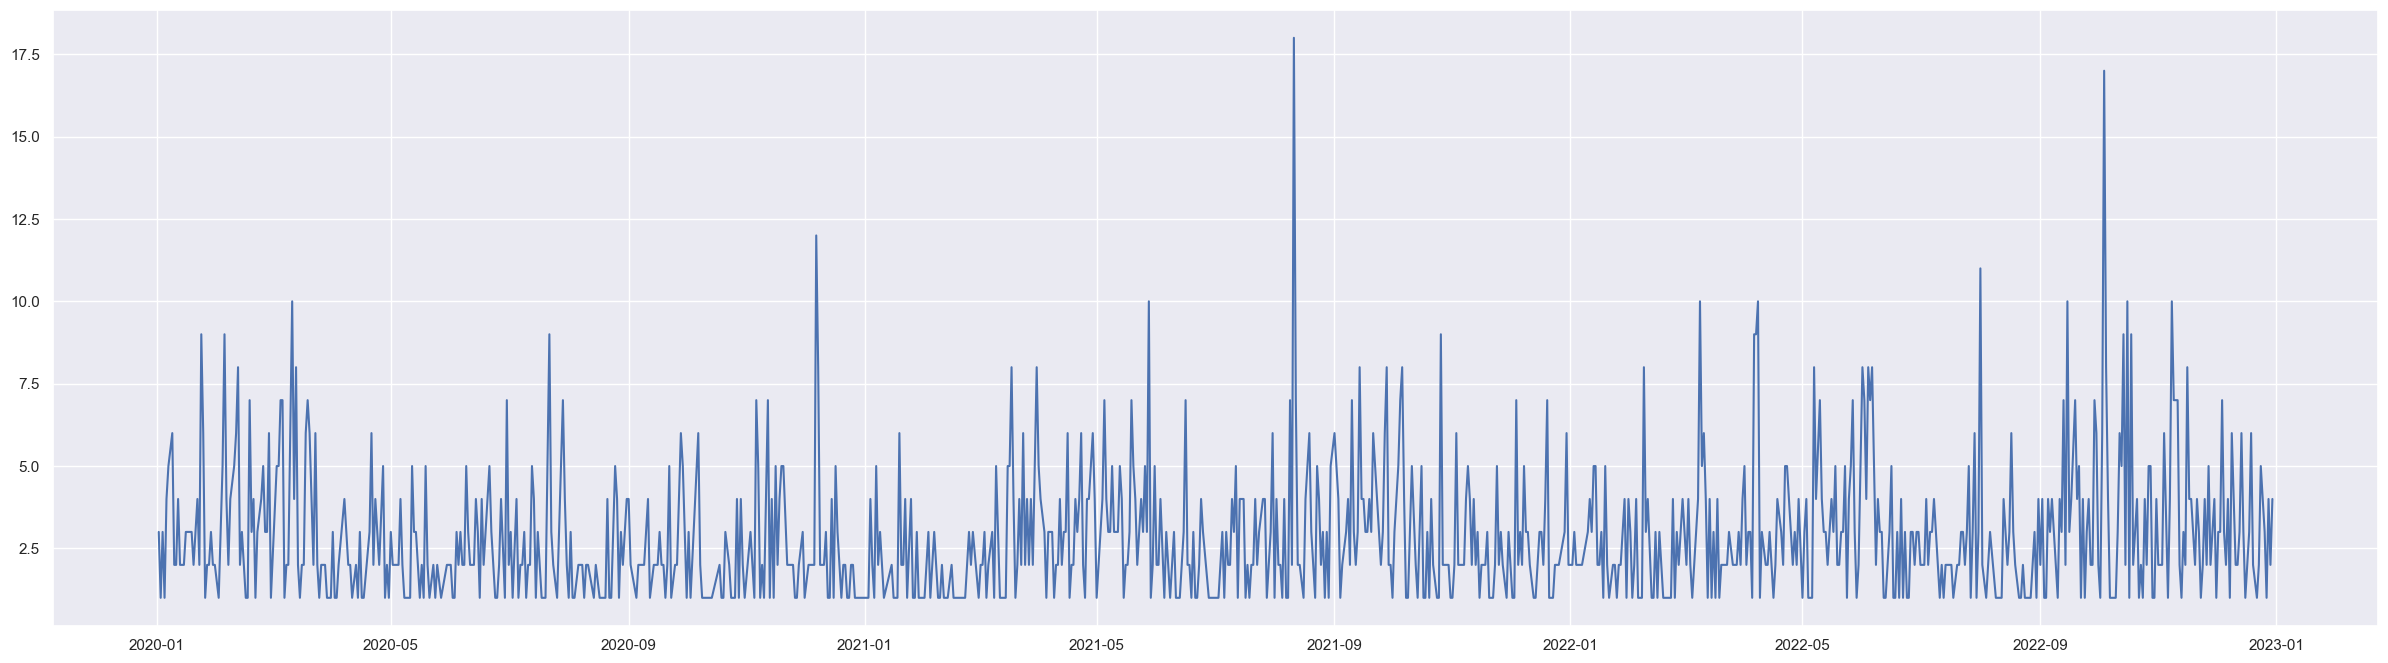

In [103]:
tweets_by_day = insurance_list.groupby("Date").count()
sns.set(rc={"figure.figsize":(30,8)})
plt.plot(tweets_by_day["Content"])
plt.show()

In [104]:
#Visualising unique values
def get_unique_values(data_frame):
    unique_frame = pd.DataFrame()
    unique_frame["Columns"] = data_frame.columns
    values = []
    for column in data_frame.columns:
        no_unique = data_frame[column].nunique()
        values.append(no_unique)
    unique_frame["Uniques"] = values
    return unique_frame

In [105]:
insurance_no_hashtags = insurance_list.drop(columns = ["Word Count"])
unique_data_frame = get_unique_values(insurance_no_hashtags)
print(unique_data_frame)

           Columns  Uniques
0             Date      936
1               Id     2737
2          Content     2730
3         Username     1229
4         Hashtags      512
5  Cleaned Content     2718


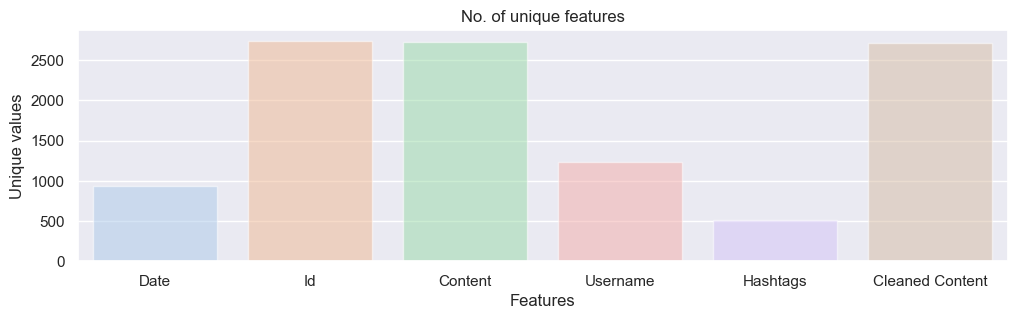

In [106]:
fig, axis = plt.subplots(1,1, figsize = (12,3))
col = sns.color_palette("pastel")
sns.set_theme(style = "whitegrid")
sns.barplot(x=unique_data_frame["Columns"],y=unique_data_frame["Uniques"],palette=col,alpha =0.5)
plt.title("No. of unique features")
plt.xlabel("Features")
plt.ylabel("Unique values")
plt.show()

In [172]:
def frequency_plot(df,title,feature,xlabel, color_scheme):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]

    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(x = df[feature],data=df, order = df[feature].value_counts().index[:20], palette=color_scheme)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")

    plt.title(title)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()


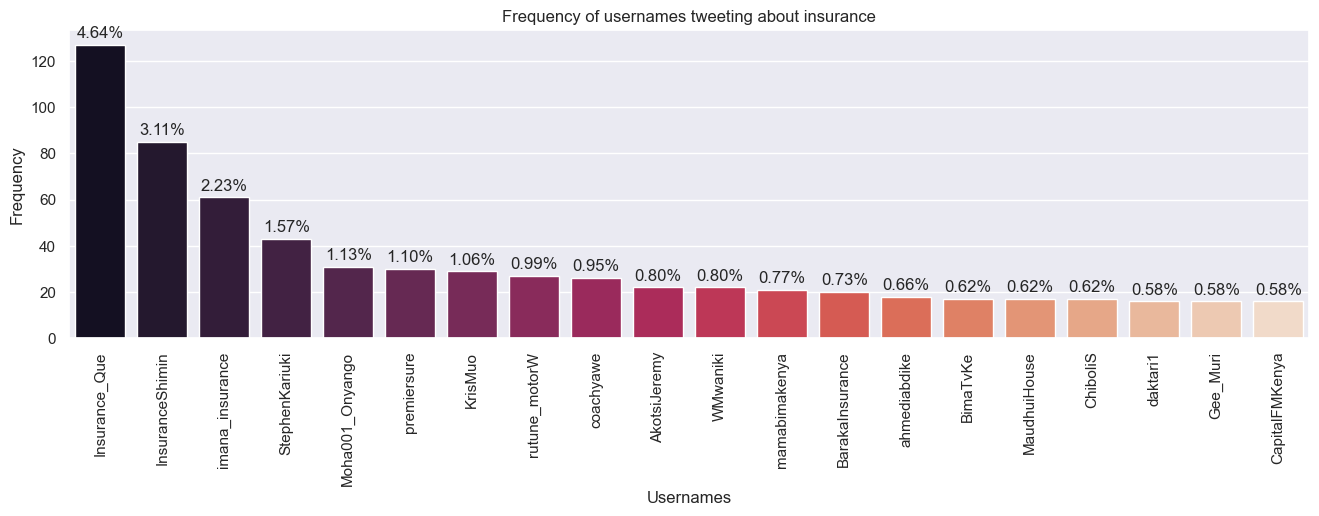

In [173]:
frequency_plot(insurance_list,"Frequency of usernames tweeting about insurance","Username","Usernames","rocket")

# 7. Sentiment Models

In [142]:
#TextBlob Model
def textblob_get_sentiment(text):
   text_blob_analyser = TextBlob(text)

   if text_blob_analyser.sentiment.polarity > 0:
      return "Positive"
   elif text_blob_analyser.sentiment.polarity == 0:
      return "Neutral"
   else:
      return "Negative"

textblob_tweet_sentiment = insurance_list["Cleaned Content"].apply(lambda text: textblob_get_sentiment(text))


#Vader Model
analyser = SentimentIntensityAnalyzer()
polarity_scores = insurance_list["Cleaned Content"].apply(lambda word: analyser.polarity_scores(word))
vader_sentiment_score = pd.concat([polarity_scores.apply(pd.Series)])
vader_sentiment_score.loc[vader_sentiment_score["compound"]== 0, "Label"] = "Neutral"
vader_sentiment_score.loc[vader_sentiment_score["compound"]> 0, "Label"] = "Positive"
vader_sentiment_score.loc[vader_sentiment_score["compound"]< 0, "Label"] = "Negative"
vader_sentiment_score.head()



,neg,neu,pos,compound,Label
2736,0.000,0.914,0.086,0.4404,Positive
2735,0.040,0.960,0.000,-0.1027,Negative
2734,0.292,0.560,0.148,-0.5574,Negative
2733,0.000,0.912,0.088,0.5106,Positive
2731,0.074,0.896,0.029,-0.2973,Negative


In [143]:
insurance_list["TextBlob Sentiment"] = textblob_tweet_sentiment
insurance_list["Vader Sentiment"] = vader_sentiment_score["Label"]
insurance_list

,Date,Id,Content,Username,Hashtags,Cleaned Content,Word Count,TextBlob Sentiment,Vader Sentiment
2736,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma,(),marvingakunyi it has alot of humility in it ho...,33,Neutral,Positive
2735,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu,"('UHC',)",healthcare financing nhifkenya enhanced nhif u...,44,Neutral,Negative
2734,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira,(),this cancer insurance cover by icealion is wha...,17,Neutral,Negative
2733,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola,"('SocialGood', 'DigitalHumanitarian', 'ItCould...",autoxpresskenya to the rescue after tyre bur...,41,Neutral,Positive
2731,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya,(),johnkieti ma3route policeke no its actually co...,50,Negative,Negative
...,...,...,...,...,...,...,...,...,...
4,2022-12-29,1608476916591255553,Insurance firms and character development 🤝🏽,BigMankera,(),insurance firms and character development,5,Neutral,Neutral
3,2022-12-30,1608733642301530112,"If you are comprehensively covered, then remem...",BimaTvKe,"('towing', 'comprehensive', 'insurance', 'acci...",if you are comprehensively covered then rememb...,36,Neutral,Negative
2,2022-12-30,1608760391974387713,What on this inflation and policy is my new In...,NyambuG,(),what on this inflation and policy is my new in...,11,Positive,Neutral
1,2022-12-30,1608795988327821312,A culture of doing routine checks should be in...,NairobiMedTech_,(),a culture of doing routine checks should be in...,17,Neutral,Neutral


In [144]:
positive_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Positive"])
negative_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Negative"])
neutral_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Neutral"])
sentiment_data = (["Positive",positive_count],["Neutral",neutral_count],["Negative",negative_count])
sentiment_count = pd.DataFrame(sentiment_data,columns=["Sentiment","Count"])
sentiment_count

,Sentiment,Count
0,Positive,1290
1,Neutral,709
2,Negative,738


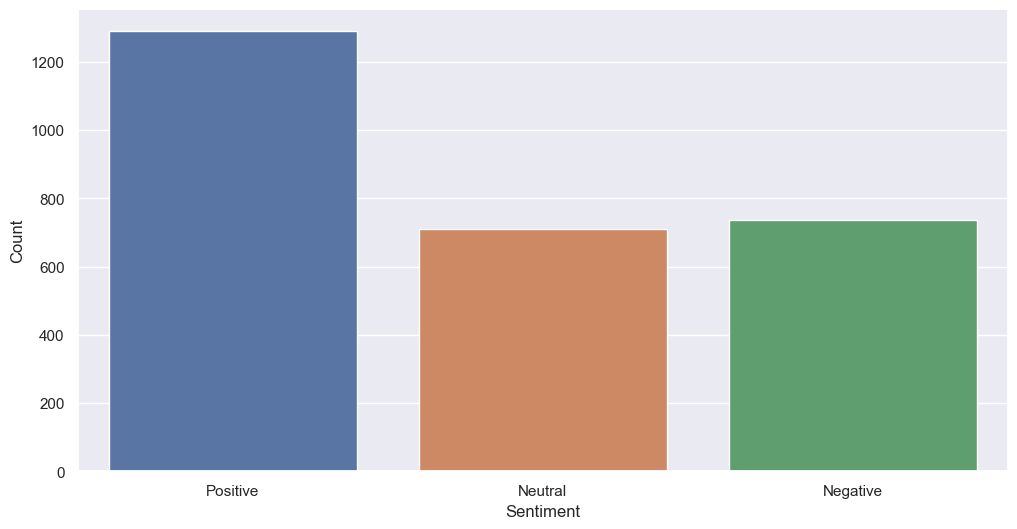

In [145]:
plt.figure(figsize=(12,6))
axis = sns.barplot(data = sentiment_count,x = "Sentiment",y="Count")


In [154]:
new_stopwords = ["insurance", "cover","policy","underwriter", "insured", "insurer", "underwriter", "insure","amp","get"]
stop_words = stopwords.words("english")
stop_words.extend(new_stopwords)


In [152]:
negative_tweets = insurance_list[insurance_list["Vader Sentiment"]== "Negative"]
negative_text = " ".join(i for i in negative_tweets["Cleaned Content"])

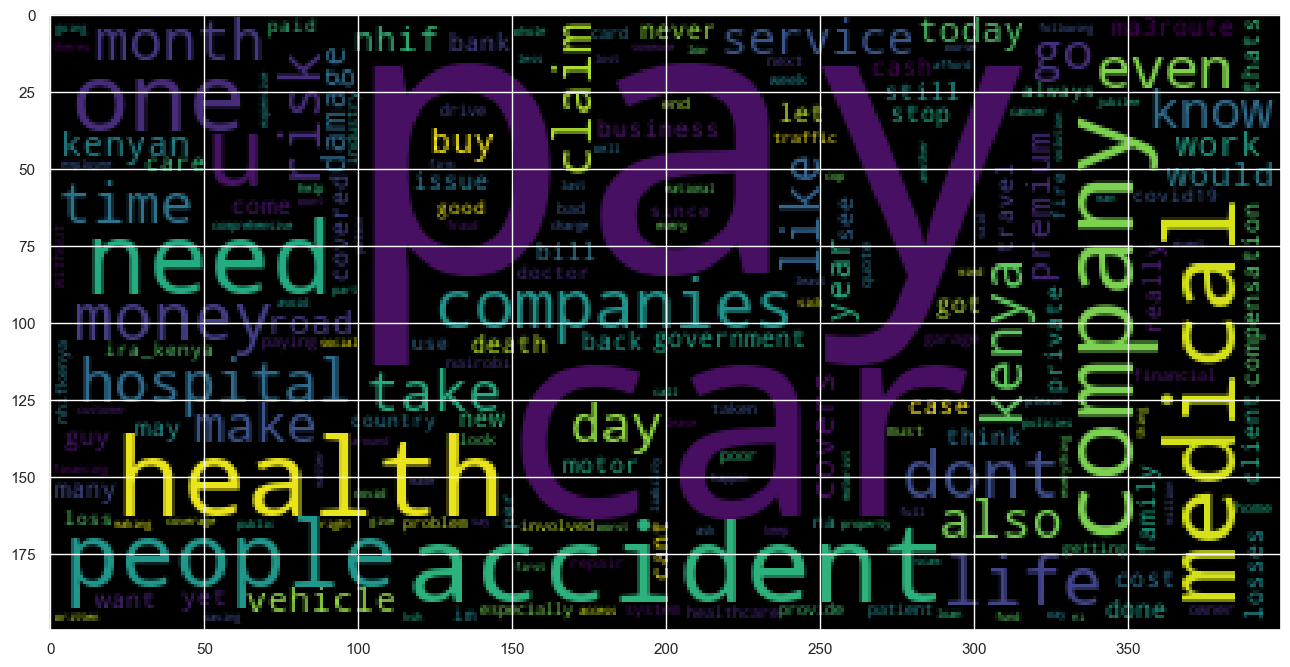

In [155]:
word_cloud_negative = WordCloud(stopwords=set(stop_words)).generate(negative_text)
plt.imshow(word_cloud_negative)
plt.show()

In [157]:
positive_tweets = insurance_list[insurance_list["Vader Sentiment"]== "Positive"]
positive_text = " ".join(i for i in negative_tweets["Cleaned Content"])

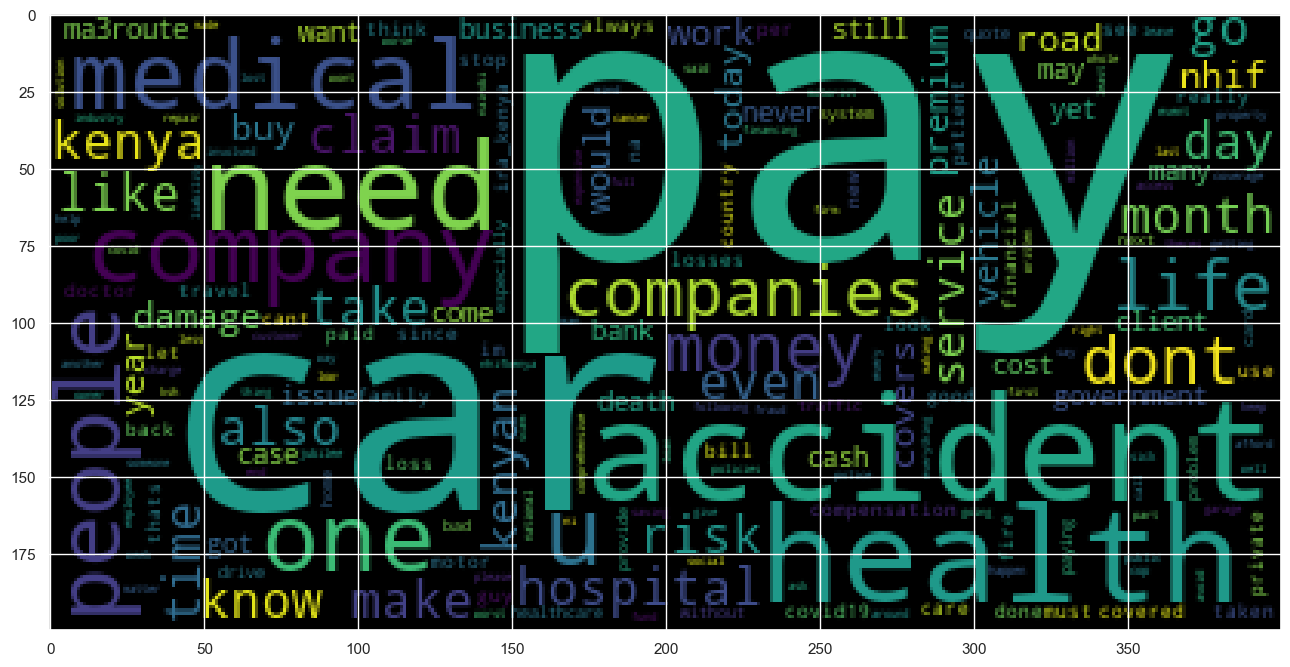

In [158]:
word_cloud_positive = WordCloud(stopwords=set(stop_words)).generate(positive_text)
plt.imshow(word_cloud_positive)
plt.show()

In [159]:
neutral_tweets = insurance_list[insurance_list["Vader Sentiment"]== "Neutral"]
neutral_text = " ".join(i for i in negative_tweets["Cleaned Content"])

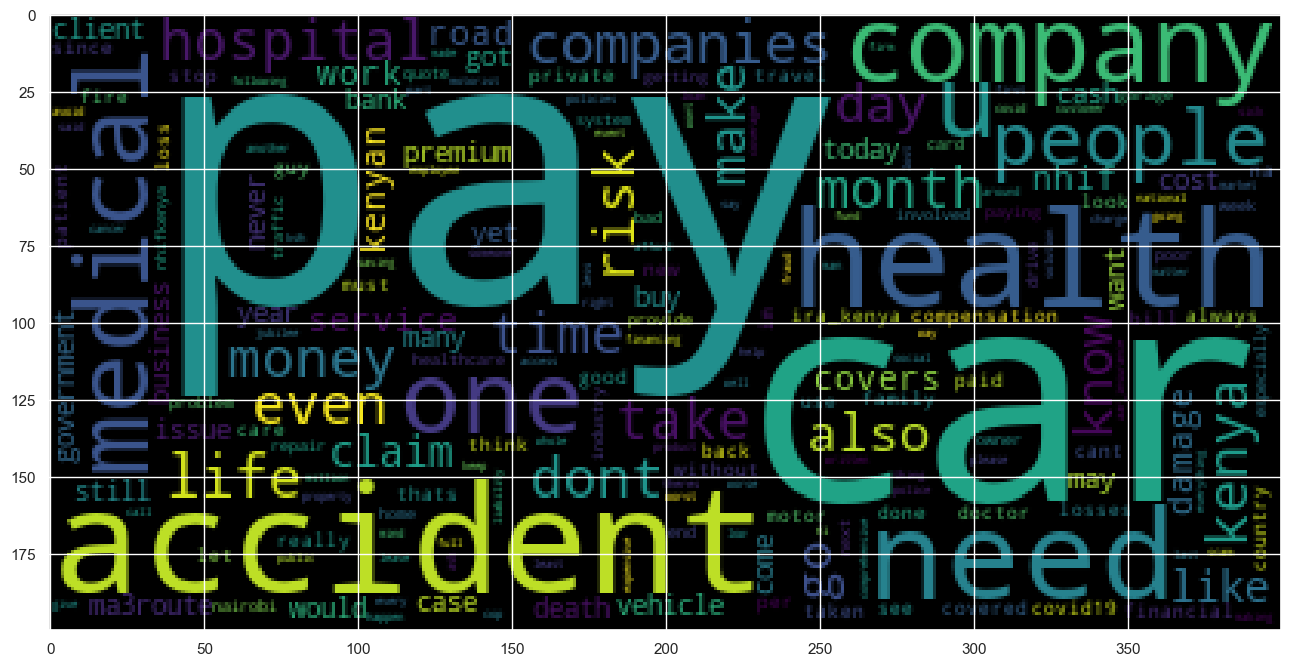

In [160]:
word_cloud_neutral = WordCloud(stopwords=set(stop_words)).generate(neutral_text)
plt.imshow(word_cloud_neutral)
plt.show()

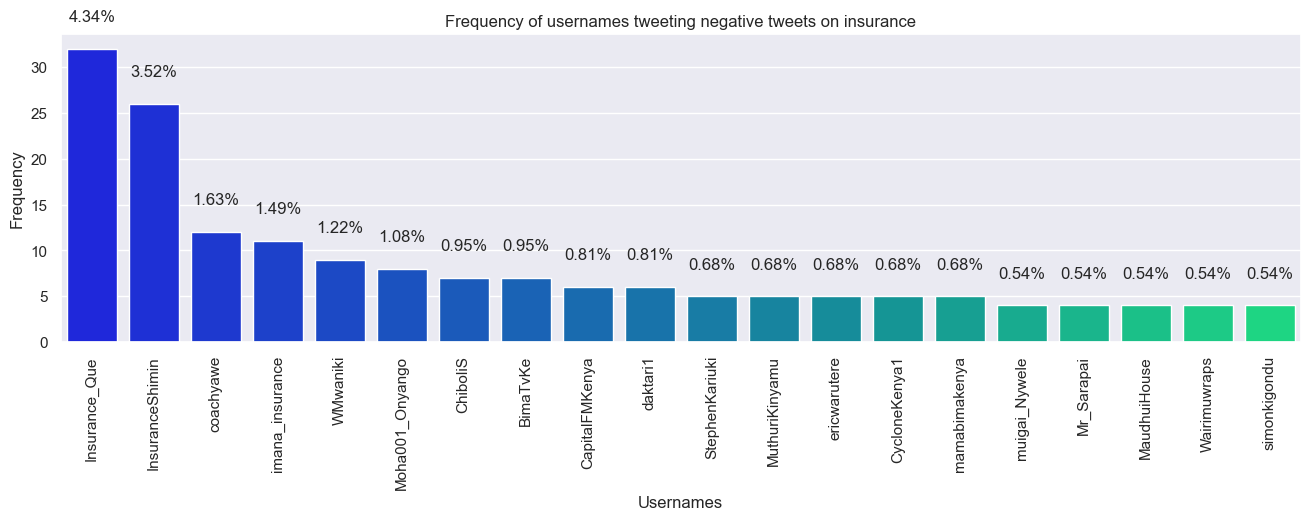

In [174]:
frequency_plot(negative_tweets,"Frequency of usernames tweeting negative tweets on insurance","Username","Usernames","winter")

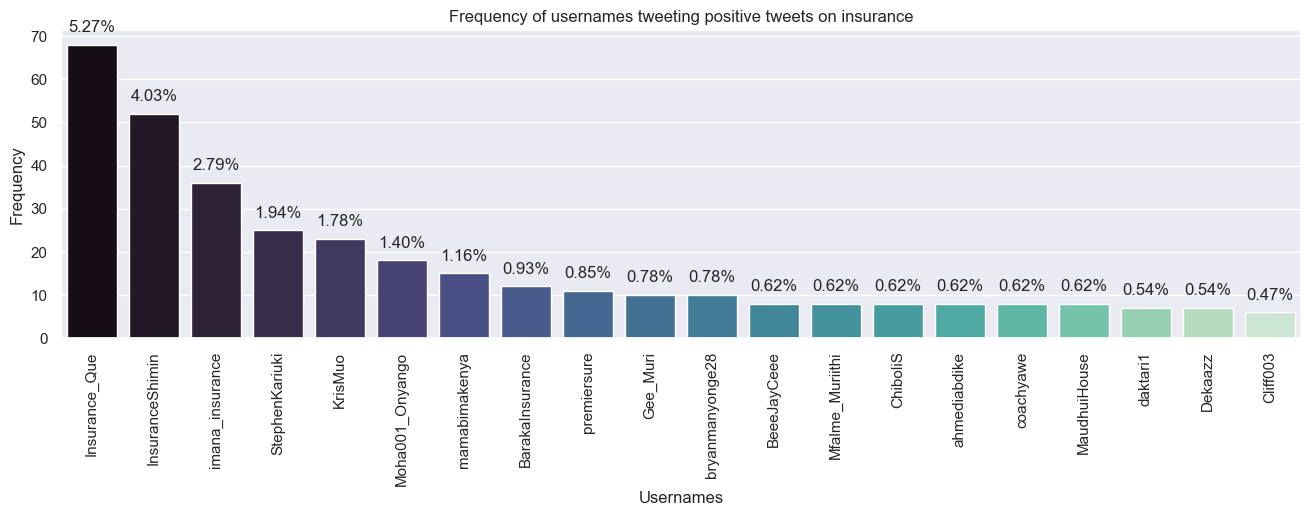

In [177]:
frequency_plot(positive_tweets,"Frequency of usernames tweeting positive tweets on insurance","Username","Usernames","mako")


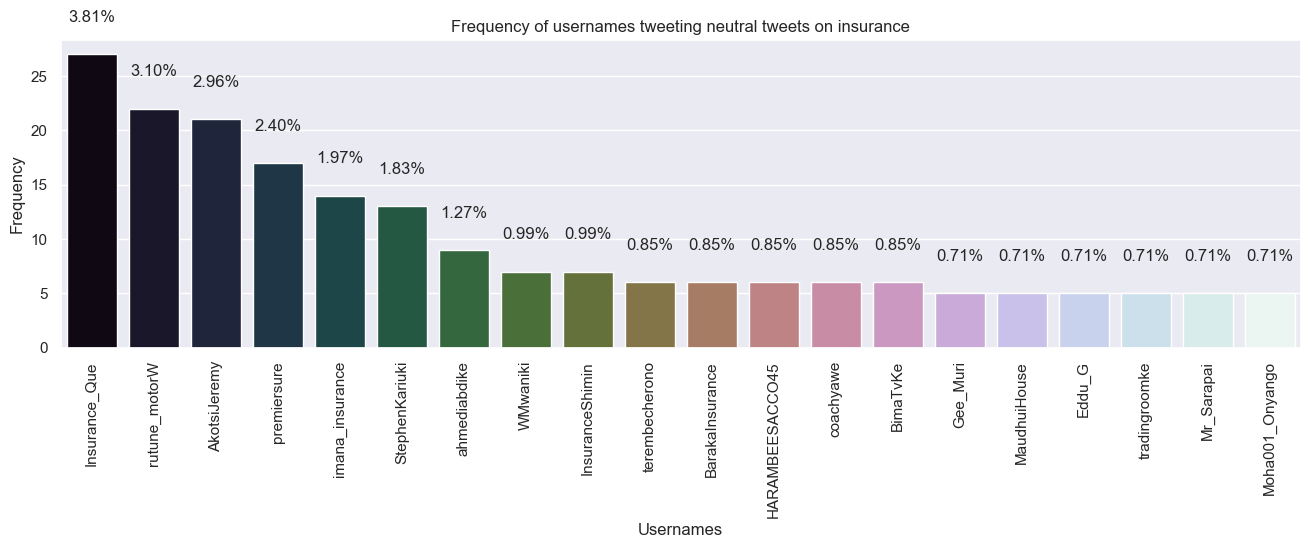

In [179]:
frequency_plot(neutral_tweets,"Frequency of usernames tweeting neutral tweets on insurance","Username","Usernames","cubehelix")
